Este agarra los audio segments de audio_segments/, los procesa, y carga los spectrograms finales a spect/

In [2]:
import os, sys
import pandas as pd
from PIL import Image

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util

In [ ]:
# # OLD!
# def load_spectrograms(df, source_dir, spectrogram_dir, output_csv_path, test_audios_dir=None, noise_reduce=True,
#                     srate=32000, segment_sec=5.0, threshold_factor=0.5, mels=224, hoplen=512, nfft=2048):
#     '''Gets the audio files from the source directory, processes them to create spectrograms, and saves 
#     the spectrograms as images in the specified directory. It also creates a CSV file denoting all the 
#     final spectrogram samples and their corresponding class IDs after generating new samples from segments.

#     Args:
#         df (pd.DataFrame): DataFrame containing at least 'filename' and 'class_id' columns.
#         source_dir (str): Directory where the original audio (.ogg) files are located.
#         spectrogram_dir (str): Directory to save generated spectrogram .png files.
#         output_csv_path (str): Path to save the output CSV mapping 'filename' to 'class_id'.
#         test_audios_dir (str, optional): Directory to save first 10 segmented audio samples as .wav files for inspection. Defaults to None.
#         noise_reduce (bool, optional): Whether to apply noise reduction to the audio files. Defaults to False.
#         sr (int, optional): Target sampling rate for audio loading. Defaults to 32000.
#         segment_sec (float, optional): Duration (in seconds) of each extracted segment. Defaults to 5.0.
#         threshold_factor (float, optional): Factor to multiply global RMS mean to set segment inclusion threshold. Defaults to 0.5.
#         mels (int, optional): Number of mel bands for the spectrogram. Defaults to 224.
#         hoplen (int, optional): Hop length for the spectrogram. Defaults to 512.
#         nfft (int, optional): FFT window size for the spectrogram. Defaults to 2048.
#     '''

#     samples_per_segment = int(sr * segment_sec)
#     rows = []
#     saved_test_audios = 0  # Counter for test audio samples
#     low_rms = 0  # Counter for segments with low RMS

#     for _, row in df.iterrows():
#         filename = row['filename']
#         class_id = row['class_id']
#         audio_path = os.path.join(source_dir, filename)

#         try:
#             y, srate = util.lbrs_loading(audio_path, srate=sr, mono=True)
#         except:
#             print(f"Error loading audio file {filename} from {source_dir}. Skipping.")
#             continue

#         threshold = util.get_rmsThreshold(y, frame_len=2048, hop_len=hoplen, thresh_factor=0.75)
#         segments_per_audio = 0  # Counter for segments per audio file

#         for start in range(0, len(y) - samples_per_segment + 1, samples_per_segment):
#             if segments_per_audio >= 5:  # Limit to max 4 segments per audio
#                 break
                
#             segment = y[start:start + samples_per_segment]

#             seg_rms = np.mean(lbrs.feature.rms(y=segment)[0])
#             if seg_rms < threshold:
#                 low_rms += 1
#                 continue

#             if noise_reduce:
#                 segment = util.reduce_noise_seg(segment, srate=srate, filename=filename, class_id=class_id)

#             img, spec_path, spec_name = util.get_spec_image(segment, srate=srate, mels=mels, hoplen=hoplen, nfft=nfft,
#                                                             filename=filename, start=start, spectrogram_dir=spectrogram_dir)
#             Image.fromarray(img).save(spec_path)

#             # Save first 10 segmented audios as test samples
#             util.save_test_audios(segment, sr, test_audios_dir, filename, start, saved_test_audios)
#             saved_test_audios += 1

#             rows.append({'filename': spec_name, 'class_id': class_id})
#             segments_per_audio += 1

#     print(f"Total segments removed due to low RMS: {low_rms}")
#     pd.DataFrame(rows).to_csv(output_csv_path, index=False)

In [3]:
def create_spectrograms_from_segments(segments, spectrogram_dir, output_csv_path, 
                                    test_audios_dir=None, mels=224, hoplen=512, 
                                    nfft=2048, noise_reduce=True):
    """
    Create spectrograms from extracted audio segments.
    
    Args:
        segments (list): List of segment dictionaries from extract_audio_segments
        spectrogram_dir (str): Directory to save spectrogram images
        output_csv_path (str): Path to save the output CSV
        test_audios_dir (str, optional): Directory to save test audio samples
        mels (int): Number of mel bands for spectrogram
        hoplen (int): Hop length for spectrogram
        nfft (int): FFT window size
        noise_reduce (bool): Whether to apply noise reduction
        
    Returns:
        pd.DataFrame: DataFrame with spectrogram metadata
    """
    print(f"Creating spectrograms from {len(segments)} segments...")
    
    os.makedirs(spectrogram_dir, exist_ok=True)
    if test_audios_dir:
        os.makedirs(test_audios_dir, exist_ok=True)
    
    spectrogram_records = []
    saved_test_audios = 0
    
    for i, segment_info in enumerate(segments):
        # Apply noise reduction if requested
        if noise_reduce:
            segment_info['audio_data'] = util.reduce_noise_seg(
                segment_info['audio_data'], 
                srate=segment_info['sr'], 
                filename=segment_info['original_filename'], 
                class_id=segment_info['class_id']
            )
        
        # Create spectrogram
        record = util.create_single_spectrogram(segment_info, spectrogram_dir, mels, hoplen, nfft)
        
        if record is not None:
            # Save test audio if requested (first 10 only)
            if test_audios_dir and saved_test_audios < 10:
                util.save_test_audio(segment_info, test_audios_dir)
                saved_test_audios += 1
            
            spectrogram_records.append(record)
    
    # Create and save final DataFrame
    final_df = pd.DataFrame(spectrogram_records)
    final_df.to_csv(output_csv_path, index=False)
    
    util.plot_summary(final_df, output_csv_path)
    return final_df

In [4]:
# Define Paths
# Input: Audio segments from AudioExtracting notebook
segments_dir = os.path.join('..', 'database', 'audio_segments')
segments_csv_path = os.path.join('..', 'database', 'meta', 'audio_segments.csv')

# Output: Spectrograms and metadata
spect_dir = os.path.join('..', 'database', 'spect')
output_csv = os.path.join('..', 'database', 'meta', 'final_spects.csv')
test_audios_dir = os.path.join('..', 'database', 'test_audios')

In [ ]:
# Preview files in segments_dir
print(f"Checking directory: {segments_dir}")
if os.path.exists(segments_dir):
    files = os.listdir(segments_dir)
    print(f"Total files in segments_dir: {len(files)}")
    print("\nFirst 10 files:")
    for file in files[:10]:
        print(f"  {file}")
    if len(files) > 10:
        print("  ...")
else:
    print("Directory does not exist!")

In [8]:
import importlib
importlib.reload(util)

print("Loading audio segments from disk...")
segments = util.load_audio_segments_from_disk(segments_csv_path, segments_dir, sr=32000)

if not segments:
    print("No segments loaded! Make sure AudioExtracting notebook has been run first.")
else:
    print(f"Loaded {len(segments)} segments from disk")
    print(f"First segment keys: {list(segments[0].keys())}")

Loading audio segments from disk...
Loaded 2390 audio segments from disk
Loaded 2390 segments from disk
First segment keys: ['audio_data', 'class_id', 'original_filename', 'segment_index', 'sr', 'class_total_segments']
Loaded 2390 audio segments from disk
Loaded 2390 segments from disk
First segment keys: ['audio_data', 'class_id', 'original_filename', 'segment_index', 'sr', 'class_total_segments']


Resetting ..\database\spect directory...
Resetting ..\database\test_audios directory...
Creating spectrograms from loaded segments...
Creating spectrograms from 2390 segments...


c:\Users\manue\miniconda3\envs\birds\Lib\site-packages\noisereduce\spectralgate\nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


Error creating spectrogram for segment 0 of XC590621.wav: Audio buffer is not finite everywhere
Error creating spectrogram for segment 1 of XC590621.wav: Audio buffer is not finite everywhere
Error creating spectrogram for segment 1 of XC590621.wav: Audio buffer is not finite everywhere
Error creating spectrogram for segment 2 of XC590621.wav: Audio buffer is not finite everywhere
Error creating spectrogram for segment 2 of XC590621.wav: Audio buffer is not finite everywhere


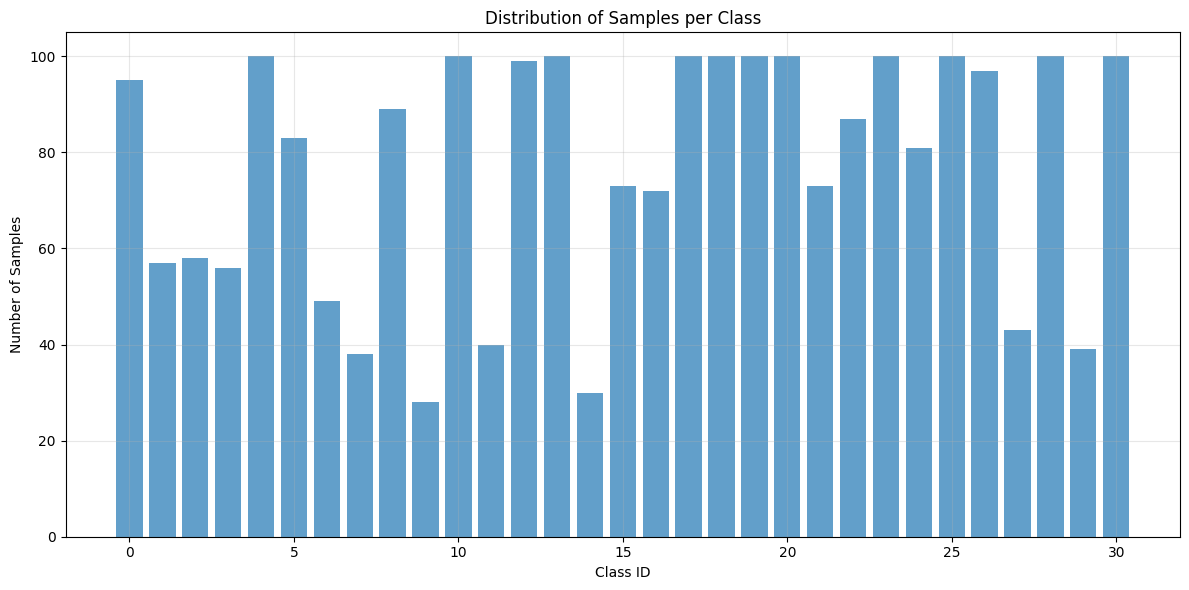

Spectrogram generation complete!


In [9]:
util.clean_dir(spect_dir)
util.clean_dir(test_audios_dir)

print("Creating spectrograms from loaded segments...")
specs = create_spectrograms_from_segments(
    segments, spect_dir, output_csv, 
    test_audios_dir=test_audios_dir, 
    mels=224, hoplen=512, nfft=2048, 
    noise_reduce=True
)

print("Spectrogram generation complete!")

Aca veo los tamaños

In [11]:
import random
amount = 20

# List all PNG files in spect_dir
spect_files = [f for f in os.listdir(spect_dir) if f.endswith('.png')]

# Fetch random images
random_files = random.sample(spect_files, min(amount, len(spect_files)))

for fname in random_files:
    img_path = os.path.join(spect_dir, fname)
    img = Image.open(img_path)
    print(f"{fname}: {img.size}")

XC549579_2_2.png: (313, 224)
XC415201_1_1.png: (313, 224)
XC379153_0_0.png: (313, 224)
XC19955_4_4.png: (313, 224)
XC457388_5_5.png: (313, 224)
XC48630_0_0.png: (313, 224)
XC84660_2_2.png: (313, 224)
XC461350_7_7.png: (313, 224)
XC364277_3_3.png: (313, 224)
XC351104_7_7.png: (313, 224)
XC586513_0_0.png: (313, 224)
XC48761_2_2.png: (313, 224)
XC351104_11_11.png: (313, 224)
XC112712_4_4.png: (313, 224)
XC288822_1_1.png: (313, 224)
XC603277_15_15.png: (313, 224)
XC412572_3_3.png: (313, 224)
XC453966_0_0.png: (313, 224)
XC364127_4_4.png: (313, 224)
XC81740_2_2.png: (313, 224)
